In [120]:
import numpy as np
from scipy.stats import iqr
import dill
import os
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import data_visualization as dv
import copy
import numba as nb
import time

import read_data_functions as rdf
import plot_functions as pf
import Optimal_Stopping_Object as oso
import Subject_Object_v2 as so

np.set_printoptions(precision=3)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
os.getcwd()

'D:\\OneDrive - University of Delaware - o365\\Subject_Data\\MatchPennies_Agent_Exp1'

# Notebook Description

- After 6/26/23 Discussion with Josh, we decided to not do the fitting movement onset time (sanity check) that I had been doing before.
- Instead, we are going to compare three different optimal models
    1. Switch cost doesn't exist at all
    2. Switch cost exists and is accounted for by optimal decision maker
       - Use True Models optimal decision time with true model output arrays
    3. Switch cost exists and is not accounted for by optimal decision maker
       - Use Expected Models optimal decision Time (should be later than True Model) with true model output arrays
       -
- metric_type will always be "optimal" for this entire script (aka there is NO fitting to experimental data)

- INSTEAD, we are fitting the gamble delay and uncertainty that spits out the data
   - If this fitting procedure can perfectly match the data, then we will have captured why people are making indecisions
   - If not there is something else (SEE BETA PARAMETER FITTING JUPYTER NOTEBOOK)


## Outline

# Initial Thangs


In [122]:
plt.style.use("cashaback_dark")
wheel = dv.ColorWheel()

# SELECT EXPERIMENT
experiment = "Exp1"

# Get path and save path 
os.chdir(f"D:\OneDrive - University of Delaware - o365\Subject_Data\MatchPennies_Agent_{experiment}")
PATH = os.getcwd()
SAVE_PATH = f"D:\\OneDrive - University of Delaware - o365\\Subject_Data\\MatchPennies_Agent_{experiment}\\Figures\\"
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

# Fields pull and pull list
figures_pull_list = []
figures_pull_list_control = []
figures_pull_list_task = []
fields_pull = []
with open(PATH + "\\Figures_Pull_List.txt", "r") as pull_file:
    figures_pull_list = pull_file.read().splitlines()
with open(PATH + "\\Fields_Pull.txt", "r") as fields_pull:
    fields_pull = fields_pull.read().splitlines()
num_subjects = len(figures_pull_list)
if experiment == "Exp2":
    tp3_title = "Win = 1\nIncorrect = 0\nIndecision = 0"
    tp4_title = "Win = 1\nIncorrect = -1\nIndecision = 0"
    tp5_title = "Win = 1\nIncorrect = 0\nIndecision = -1"
    tp6_title = "Win = 1\nIncorrect = -1\nIndecision = -1"
    trial_block_titles = [tp3_title, tp4_title, tp5_title, tp6_title]
    num_blocks = len(trial_block_titles)
    xlabel = "Payoff Condition"
if experiment == "Exp1":
    tp3_title = "1000 (50)"
    tp4_title = "1000 (150)"
    tp5_title = "1100 (50)"
    tp6_title = "1100 (150)"
    tp7_title = "1200 (50)"
    tp8_title = "1200 (150)"
    trial_block_titles = [tp3_title, tp4_title, tp5_title, tp6_title, tp7_title, tp8_title]
    num_blocks = len(trial_block_titles)
    xlabel = "Mean [SD] Agent Decision Time (ms)"
num_subjects

20

# Pickle Data


In [123]:
if "subject_objects" not in locals():
    subject_objects = rdf.generate_subject_objects(experiment)
    group = so.Group(
        subject_objects,
        select_trials="All Trials",
        num_stds_for_reaction_time=2,
        task_leave_time_metric_name="player_velocity_task_leave_time_thresh",
        task_movement_time_metric_name="player_velocity_task_movement_time_thresh",
        reaction_time_metric_name="player_velocity_reaction_time_thresh",
        reaction_movement_time_metric_name="player_velocity_reaction_movement_time_thresh",
    )
    group.analyze_data()

# Create Model


Set inputs for model

In [124]:
if experiment == "Exp1":
    rt = np.nanmedian(np.nanmedian(group.reaction_time, axis=1)) - 15
    rt_sd = np.nanmedian(np.nanstd(group.reaction_time, axis=1))

elif experiment == "Exp2":
    rt = np.nanmedian(np.nanmedian(group.react_reaction_time_only_react, axis=1)) - 30
    rt_sd = np.nanmedian(np.nanstd(group.reaction_time, axis=2))

mt                   = np.min(np.nanmedian(np.nanmedian(group.player_task_movement_time, axis=2), axis=0)) # Get movement time for the condition where they tried the hardest
mt_sd                = np.nanmedian(np.nanstd(group.player_task_movement_time, axis=1))
time_sd              = np.array([np.nanmedian(np.nanstd(group.coincidence_reach_time, axis=1))] * num_blocks)
perc_wins_both_reach = np.nanmean(group.perc_gamble_wins_when_both_decide, axis=0)
gamble_sd            = np.nanmedian(np.nanstd(group.player_gamble_task_leave_time, axis=2), axis=0)
agent_sds            = np.nanmean(np.nanstd(group.agent_task_leave_time, axis=2), axis=0)
agent_means          = np.nanmean(np.nanmean(group.agent_task_leave_time, axis=2), axis=0)



Run model without switch cost

In [125]:
# Switch cost is the switch delay and the switch sd
# In this case we 
model_regular_reward = oso.ModelConstructor(
    experiment=experiment,
    num_blocks=num_blocks,
    num_timesteps=1800,
    BETA_ON=False,
    agent_means=agent_means,
    agent_sds=agent_sds,
    reaction_time={"true": rt, "exp": rt},
    movement_time={"true": mt, "exp": mt},
    reaction_sd={"true": rt_sd, "exp": rt_sd},
    movement_sd={"true": mt_sd, "exp": mt_sd},
    timing_sd={"true": time_sd, "exp": time_sd},
    perc_wins_when_both_reach=perc_wins_both_reach,
    gamble_switch_delay={"true": 70, "exp": 0},
    gamble_switch_sd={'true': 35, 'exp': 0},
    electromechanical_delay={"true": 50, "exp": 50},
    electromechanical_sd={"true": 10, "exp": 10},
    gamble_delay_known=True,
    gamble_sd_known=True,
    switch_cost_exists = True,
    expected=False,
    win_reward=1,
    incorrect_cost=-0,
    indecision_cost=0,
)


Run model and fit the switch cost

In [201]:
win_reward = 1.0
indecision_cost = 0.3
incorrect_cost = -0.3
#* Run true model and fit the gamble delay
model_altered_reward = oso.ModelConstructor(
    experiment=experiment,
    num_blocks=num_blocks,
    num_timesteps=1800,
    BETA_ON=False,
    agent_means=agent_means,
    agent_sds=agent_sds,
    reaction_time={"true": rt, "exp": rt},
    movement_time={"true": mt, "exp": mt},
    reaction_sd={"true": rt_sd, "exp": rt_sd},
    movement_sd={"true": mt_sd, "exp": mt_sd},
    timing_sd={"true": time_sd, "exp": time_sd},
    perc_wins_when_both_reach=perc_wins_both_reach,
    gamble_switch_delay={'true': 0, 'exp': 0},
    gamble_switch_sd={"true": 0, "exp": 0},
    electromechanical_delay={"true": 50, "exp": 50},
    electromechanical_sd={"true": 10, "exp": 10},
    gamble_delay_known=True,
    gamble_sd_known=True,
    switch_cost_exists = True,
    expected=False,
    win_reward=win_reward,
    incorrect_cost=incorrect_cost,
    indecision_cost=indecision_cost,
)

if False:
    free_params_init = {
                        'win_reward':1,
                        'incorrect_cost': 0,
                        'indecision_cost':0,
                        }

    targets = np.array([
        [np.nanmedian(np.nanmedian(group.player_task_leave_time, axis=2),axis=0)],
        [np.nanmedian(np.nanstd(group.player_task_leave_time,axis=2),axis=0)],
        # [np.nanmedian(group.player_perc_indecisions,axis=0)/100]
    ])
    metric_keys = ['wtd_leave_time','wtd_leave_time_sd']#,'prob_indecision']
    model_fit_object = oso.ModelFitting(model=model_altered_reward)
    res = model_fit_object.run_model_fit_procedure(
            free_params_init=free_params_init,
            targets=targets,
            metric_keys=metric_keys,
            bnds=[(-1,1),(-1,1),(-1,1)],
            tol=0.000000001,
            method='basinhopping',
            niter= 50,
        )
    print(f'Initial Parameters: {free_params_init}')
    print(f'Win Reward: {model_altered_reward.inputs.win_reward}')
    print(f'Incorrect Cost: {model_altered_reward.inputs.incorrect_cost}')
    print(f'Indecision Cost: {model_altered_reward.inputs.indecision_cost}')

In [202]:
res

                        fun: 1.6163816071682091
 lowest_optimization_result:  final_simplex: (array([[ 1.244, -0.048,  0.035],
       [ 1.244, -0.048,  0.035],
       [ 1.244, -0.048,  0.035],
       [ 1.244, -0.048,  0.035]]), array([1.616, 1.616, 1.616, 1.616]))
           fun: 1.6163816071682091
       message: 'Optimization terminated successfully.'
          nfev: 68
           nit: 25
        status: 0
       success: True
             x: array([ 1.244, -0.048,  0.035])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 3830
                        nit: 50
                          x: array([ 1.244, -0.048,  0.035])

Plot loss map

In [203]:
if True:
    if model_fit_object.parameter_arr.ndim==1:
        plt.ioff()
        params = np.array(model_fit_object.parameter_arr)
        loss = model_fit_object.loss_store
        fig = plt.figure()
        ax = fig.add_subplot()
        ax.scatter(params, loss)
        ax.set_xlabel('Guess Delay')
        ax.set_ylabel('Loss')
        ax.set_ylim(0,6)
        plt.show()


In [204]:
%matplotlib notebook

if model_fit_object.parameter_arr.squeeze().ndim>1:
    plt.ion()
    params = np.array(model_fit_object.parameter_arr)
    loss = model_fit_object.loss_store
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(params[:,0], params[:,1], loss)
    ax.set_xlabel('Guess Delay')
    ax.set_ylabel('Guess SD')
    plt.show()

<IPython.core.display.Javascript object>

Plot optimal decision time vs guess delay

In [205]:
%matplotlib inline
if False:
    yaxis_metric = model_fit_object.leave_time_store
    params = np.array(model_fit_object.parameter_arr[:,0])
    fig,axes = plt.subplots(2,3,figsize=(20,9),dpi=300)
    for i,ax in enumerate(axes.flatten()):
        ax.scatter(params, yaxis_metric[:,i])
        if i == 0 or i == 3:
            ax.set_ylabel('Movement Onset Time (ms)')
        if i>2:
            ax.set_xlabel('Guess Switch Delay')
        ax.axhline(targets.flatten()[i])
        ax.axvline(model_altered_reward.inputs.gamble_switch_delay['true'],c='grey')
        ax.set_yticks(np.arange(0,1600,250))
        ax.set_ylim(500,1600)
        ax.set_title(trial_block_titles[i])
        
    plt.show()

## Shorten the function names


In [206]:
get_no_switch_metric = model_regular_reward.results.get_metric
get_switch_metric = model_altered_reward.results.get_metric
#! To get the value for not knowing the switch cost, you use the model_switch get_metric function with the model_unknown decision times 
example = get_no_switch_metric(model_altered_reward.score_metrics.prob_indecision,metric_type='optimal')
example

array([0.085, 0.099, 0.076, 0.059, 0.   , 0.008])

# Plots


In [207]:
save = False

In [208]:
# optimal_model_full_knowledge.plot_optimals(metrics = ['exp_reward','prob_making_given_reaction','prob_indecision_given_reaction','prob_agent_has_gone'])#,'exp_reward_reaction','exp_reward_gamble','prob_selecting_reaction'])

Predicted Decision Time


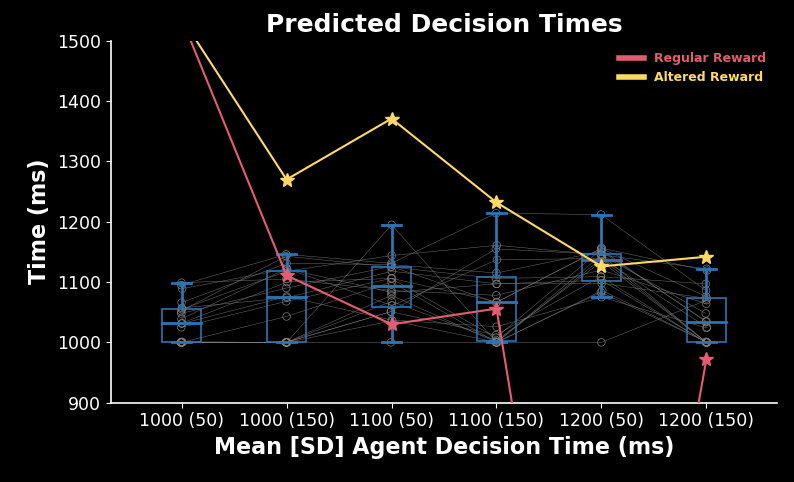

In [209]:
group.predict_stopping_times(model_altered_reward.inputs.gamble_delay["true"])
metric = group.combine_all_subjects("player_stopping_times")
regular_reward_metric = model_regular_reward.results.optimal_decision_time
altered_reward_metric = model_altered_reward.results.optimal_decision_time

w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(900, 1600, 100)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric,
    model_data_list=[regular_reward_metric, altered_reward_metric],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    xlocs=xlocs,
    box_width=bw,
    colors=wheel.seth_blue,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

ax.set_xticks(xlocs)
ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_xlim(min(xlocs) - 1.8 * bw, max(xlocs) + 1.8 * bw)
ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xlabel(xlabel)
ax.set_ylabel("Time (ms)")
ax.set_title("Predicted Decision Times")
if save:
    plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
axmain.set_axis_off()
plt.show()

LEave Target Time


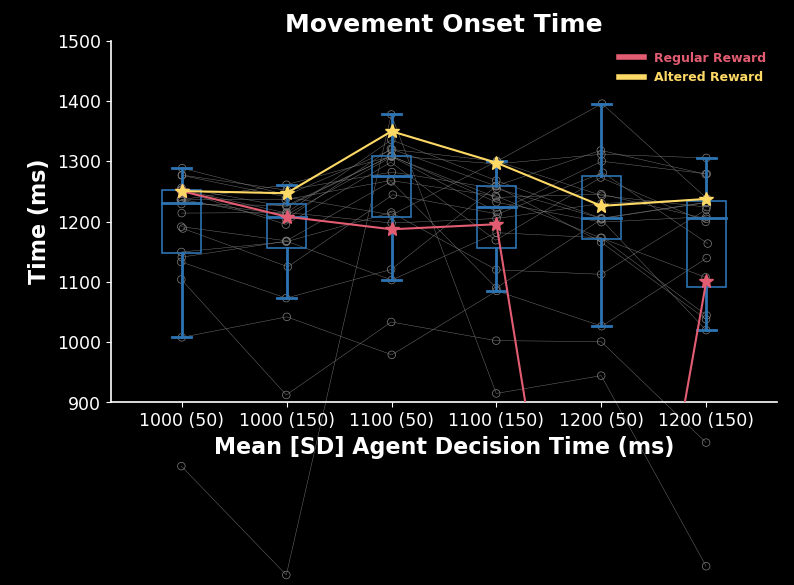

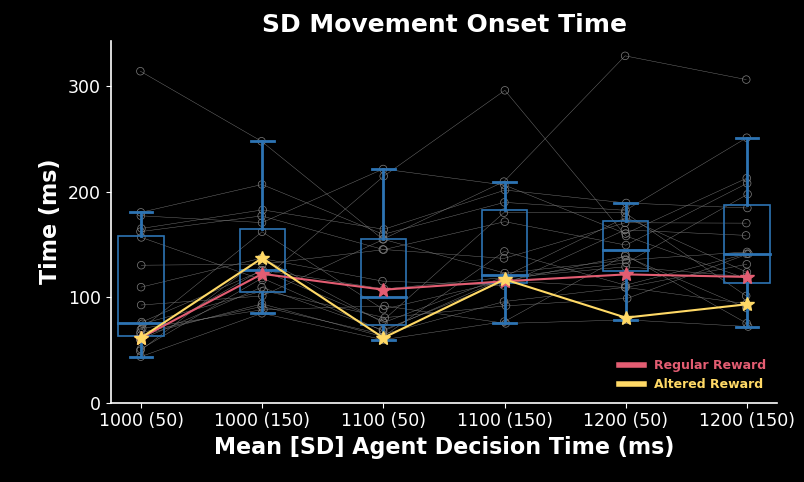

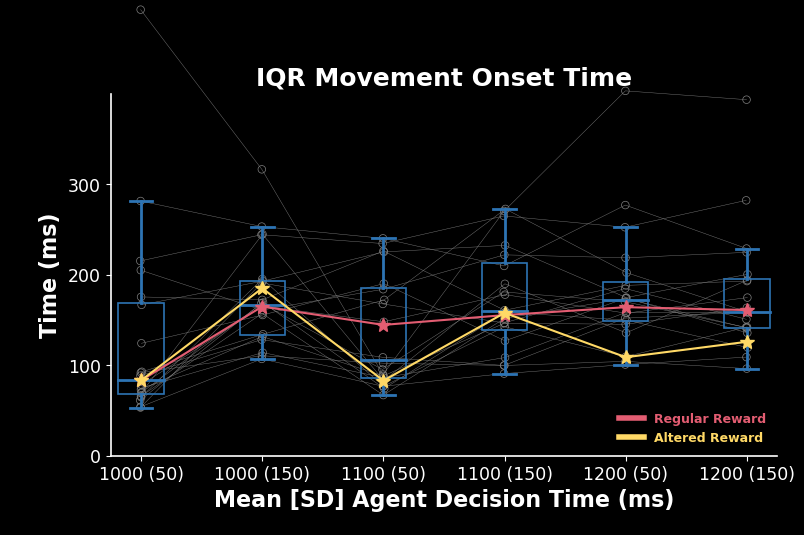

In [210]:
metric = np.nanmedian(group.player_task_leave_time, axis=2)
regular_reward_metric = get_no_switch_metric(model_regular_reward.player_behavior.wtd_leave_time,metric_type='optimal')
altered_reward_metric = get_switch_metric(model_altered_reward.player_behavior.wtd_leave_time,metric_type='optimal')
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(900, 1600, 100)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric,
    model_data_list=[regular_reward_metric, altered_reward_metric],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    xlocs=xlocs,
    box_width=bw,
    colors=wheel.seth_blue,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

ax.set_xticks(xlocs)
ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_xlim(min(xlocs) - 1.8 * bw, max(xlocs) + 1.8 * bw)
ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xlabel(xlabel)
ax.set_ylabel("Time (ms)")
ax.set_title("Movement Onset Time")
if save:
    plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
axmain.set_axis_off()
plt.show()

##########################################

metric = np.nanstd(group.player_task_leave_time, axis=2)
regular_reward_metric = get_no_switch_metric(model_regular_reward.player_behavior.wtd_leave_time_sd,metric_type='optimal')
altered_reward_metric = get_switch_metric(model_altered_reward.player_behavior.wtd_leave_time_sd,metric_type='optimal')

w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 400, 100)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric,
    model_data_list=[regular_reward_metric, altered_reward_metric],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    xlocs=xlocs,
    box_width=bw,
    colors=wheel.seth_blue,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

ax.set_xticks(xlocs), ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_xlabel(xlabel)
ax.set_ylabel("Time (ms)")
ax.set_title("SD Movement Onset Time")
# ax.plot(xlocs,get_exp_metric(np.sqrt(model_unknown.player_behavior.gamble_reach_time_sd**2)))
if save:
    plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
axmain.set_axis_off()
plt.show()

###################################
metric = iqr(group.player_task_leave_time, axis=2)
regular_reward_metric = get_no_switch_metric(model_regular_reward.player_behavior.wtd_leave_time_iqr,metric_type='optimal')
altered_reward_metric = get_switch_metric(model_altered_reward.player_behavior.wtd_leave_time_iqr,metric_type='optimal')

w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 400, 100)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric,
    model_data_list=[regular_reward_metric, altered_reward_metric],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    xlocs=xlocs,
    box_width=bw,
    colors=wheel.seth_blue,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

ax.set_xticks(xlocs), ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_xlabel(xlabel)
ax.set_ylabel("Time (ms)")
ax.set_title("IQR Movement Onset Time")
ax.set_ylim(0,400)
# ax.plot(xlocs,get_exp_metric(np.sqrt(model_unknown.player_behavior.gamble_reach_time_sd**2)))
if save:
    plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
axmain.set_axis_off()
plt.show()

Wins


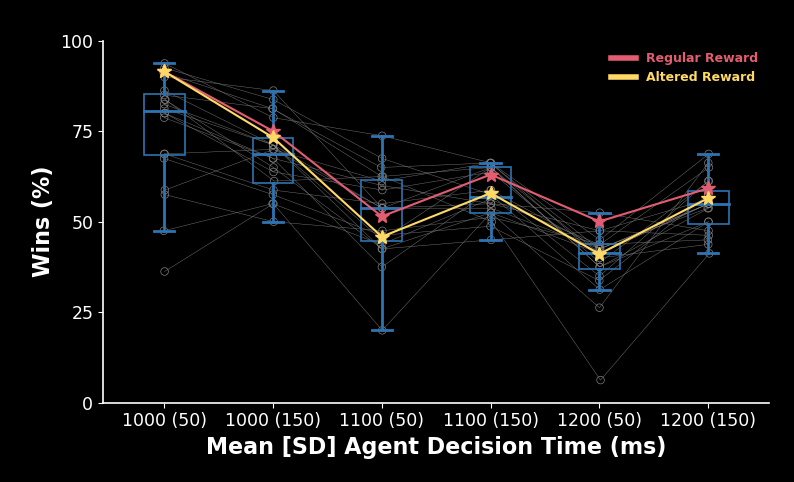

In [211]:
metric = group.player_perc_wins
regular_reward_metric = get_no_switch_metric(model_regular_reward.score_metrics.prob_win,metric_type='optimal')*100
altered_reward_metric = get_switch_metric(model_altered_reward.score_metrics.prob_win,metric_type='optimal')*100

w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)

bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric,
    model_data_list=[regular_reward_metric, altered_reward_metric],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    xlocs=xlocs,
    box_width=bw,
    colors=wheel.seth_blue,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))
ax.set_xticks(xlocs), ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0, 100)
ax.set_xlabel(xlabel)
ax.set_ylabel("Wins (%)")
# dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "wins_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Points


In [212]:
if experiment == "Exp2":
    metric = group.player_points_scored
    true_player_metric = get_true_metric(model_altered_reward.expected_reward.exp_reward, metric_type="fit") * group.num_task_trials[0]
    exp_player_metric = get_exp_metric(model_unknown.expected_reward.exp_reward, metric_type="fit") * group.num_task_trials[0]
    true_optimal_metric = get_true_metric(model_altered_reward.expected_reward.exp_reward, metric_type="optimal") * group.num_task_trials[0]
    exp_optimal_metric = get_exp_metric(model_altered_reward.expected_reward.exp_reward, metric_type="optimal") * group.num_task_trials[0]
    w, h = 10, 6
    axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
    xlocs = np.linspace(0, w, num=len(trial_block_titles))
    ylocs = np.arange(0, 125, 20)

    bw = 0.75
    pf.multiple_models_boxplot(
        ax,
        metric,
        true_player=true_player_metric,
        expected_player=exp_player_metric,
        true_optimal=true_optimal_metric,
        expected_optimal=exp_optimal_metric,
        xlocs=xlocs,
        box_width=bw,
        colors=wheel.seth_blue,
        remove_parentheses_from_labels=False,
    )

    ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))
    ax.set_xticks(xlocs), ax.set_yticks(ylocs)
    ax.set_xticklabels(trial_block_titles)
    ax.set_ylim(-20, 80)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Points Scored")
    # dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])

    if save:
        axmain.set_axis_off()
        plt.savefig(SAVE_PATH + "incorrects_with_optimal_model", dpi=400, transparent=True)
    axmain.set_axis_off()

    plt.show()

Incorrects


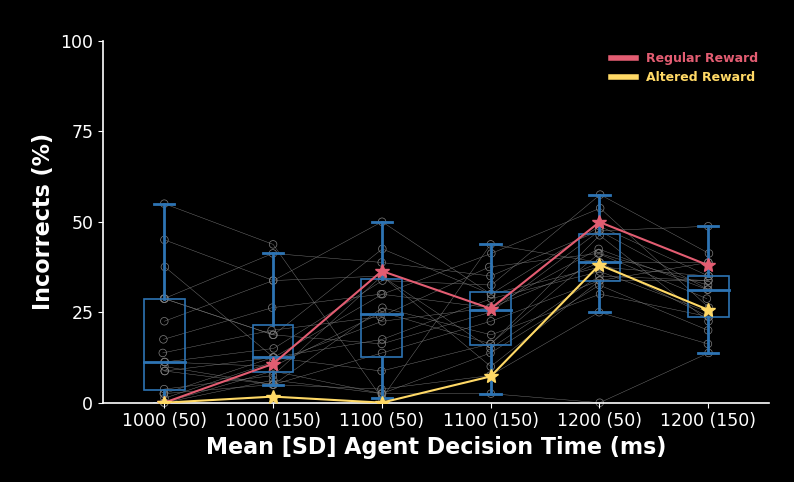

In [213]:
metric = group.player_perc_incorrects
regular_reward_metric = get_no_switch_metric(model_regular_reward.score_metrics.prob_incorrect,metric_type='optimal')*100
altered_reward_metric = get_switch_metric(model_altered_reward.score_metrics.prob_incorrect,metric_type='optimal')*100

w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)

bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric,
    model_data_list=[regular_reward_metric, altered_reward_metric],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    xlocs=xlocs,
    box_width=bw,
    colors=wheel.seth_blue,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))
ax.set_xticks(xlocs), ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0, 100)
ax.set_xlabel(xlabel)
ax.set_ylabel("Incorrects (%)")
# dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "incorrects_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Indecisions


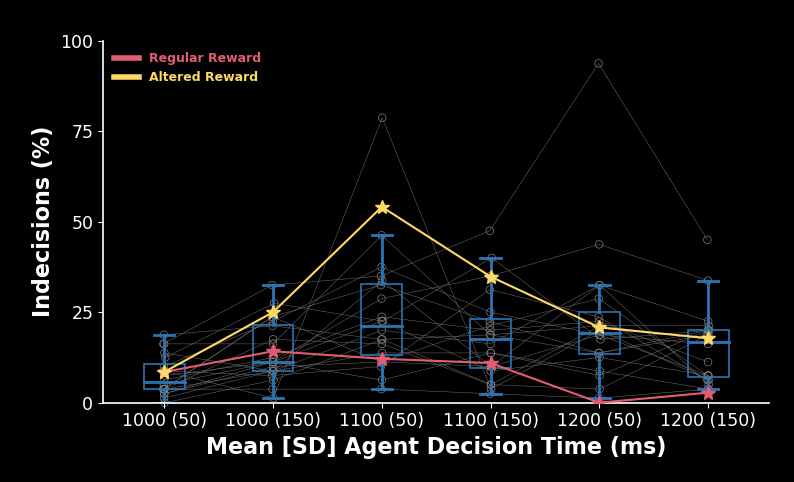

In [214]:
metric = group.player_perc_indecisions
regular_reward_metric = get_no_switch_metric(model_regular_reward.score_metrics.prob_indecision,metric_type='optimal')*100
altered_reward_metric = get_switch_metric(model_altered_reward.score_metrics.prob_indecision,metric_type='optimal')*100

w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)

bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric,
    model_data_list=[regular_reward_metric, altered_reward_metric],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    xlocs=xlocs,
    box_width=bw,
    colors=wheel.seth_blue,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))
ax.set_xticks(xlocs), ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0, 100)
ax.set_xlabel(xlabel)
ax.set_ylabel("Indecisions (%)")
# dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "indecisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

In [215]:
from scipy import stats
stats.norm.pdf(50,100,)

0.0

Wins, Incorrects, Indecisions on One plot


Correct Initial Decisions


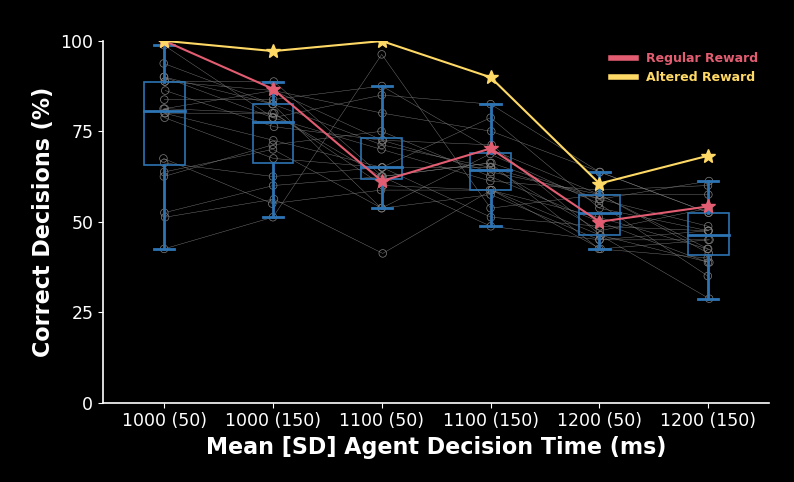

In [216]:
metric = group.phat_correct * 100
regular_reward_metric = get_no_switch_metric(model_regular_reward.score_metrics.correct_decisions,metric_type='optimal')*100
altered_reward_metric = get_switch_metric(model_altered_reward.score_metrics.correct_decisions,metric_type='optimal')*100

w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)

bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric,
    model_data_list=[regular_reward_metric, altered_reward_metric],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    xlocs=xlocs,
    box_width=bw,
    colors=wheel.seth_blue,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))
ax.set_xticks(xlocs), ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0, 100)
ax.set_xlabel(xlabel)
ax.set_ylabel("Correct Decisions (%)")
# dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "correct_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Reaction and Guess Decisions


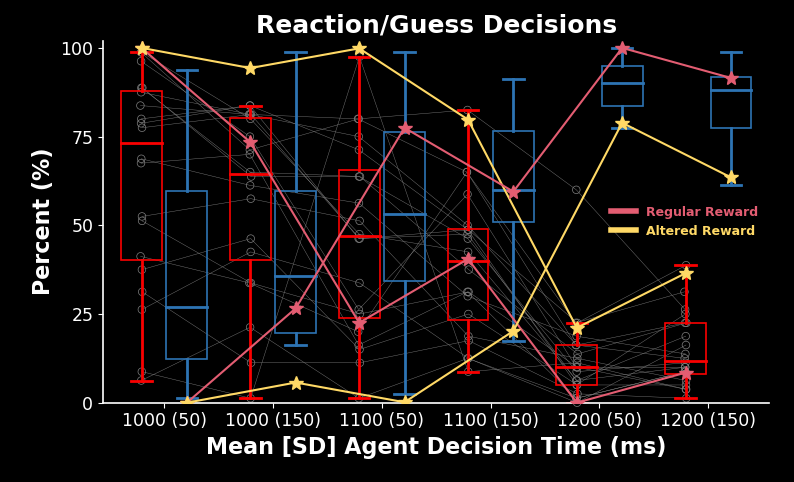

In [217]:
data_metric1 = group.combine_all_subjects("perc_reaction_decisions")
regular_reward_metric1 = get_no_switch_metric(model_regular_reward.player_behavior.prob_selecting_reaction, metric_type="optimal") * 100
altered_reward_metric1 = get_switch_metric(model_altered_reward.player_behavior.prob_selecting_reaction, metric_type="optimal") * 100

data_metric2 = group.combine_all_subjects("perc_gamble_decisions")
no_switch_metric2 = get_no_switch_metric(model_regular_reward.player_behavior.prob_selecting_gamble, metric_type="optimal") * 100
switch_metric2 = get_switch_metric(model_altered_reward.player_behavior.prob_selecting_gamble, metric_type="optimal") * 100

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[regular_reward_metric1, altered_reward_metric1],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2],
    labels=['Regular Reward','Altered Reward'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(xlabel)
ax.set_title("Reaction/Guess Decisions")
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_gamble_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Reaction and Guess Leave Times


c:\Users\Seth Sullivan\anaconda3\envs\aim1\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


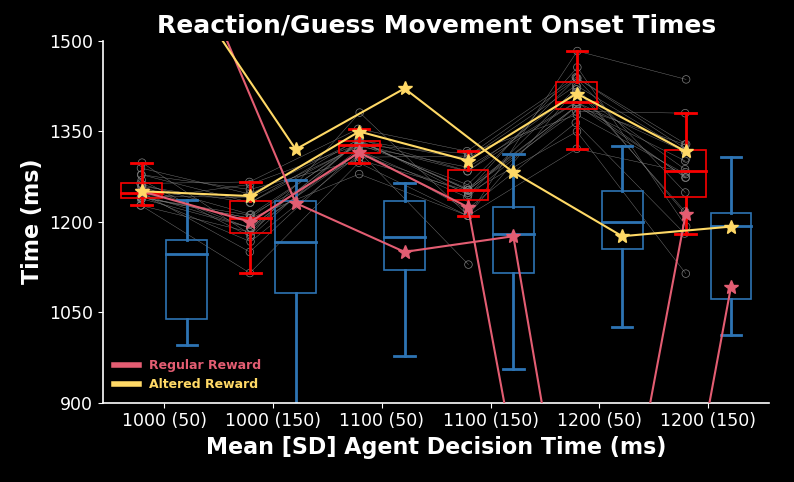

In [218]:
data_metric1 = np.nanmedian(group.player_reaction_task_leave_time, axis=2)
data_metric2 = np.nanmedian(group.player_gamble_task_leave_time, axis=2)

regular_reward_metric1 = get_no_switch_metric(model_regular_reward.player_behavior.reaction_leave_time, metric_type="optimal")
altered_reward_metric1 = get_switch_metric(model_altered_reward.player_behavior.reaction_leave_time, metric_type="optimal")
unknown_switch_metric1 = get_no_switch_metric(model_altered_reward.player_behavior.reaction_leave_time, metric_type="optimal")

no_switch_metric2 = get_no_switch_metric(model_regular_reward.player_behavior.gamble_leave_time, metric_type="optimal")
switch_metric2 = get_switch_metric(model_altered_reward.player_behavior.gamble_leave_time, metric_type="optimal")
unknown_switch_metric2 = get_no_switch_metric(model_altered_reward.player_behavior.gamble_leave_time, metric_type="optimal")

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(900, 1650, 150)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[regular_reward_metric1, altered_reward_metric1],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2],
    labels=['Regular Reward','Altered Reward'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel("Time (ms)")
ax.set_xlabel(xlabel)
ax.set_title("Reaction/Guess Movement Onset Times")
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_gamble_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Agent Reaction and Guess Movement Onset Times


c:\Users\Seth Sullivan\anaconda3\envs\aim1\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


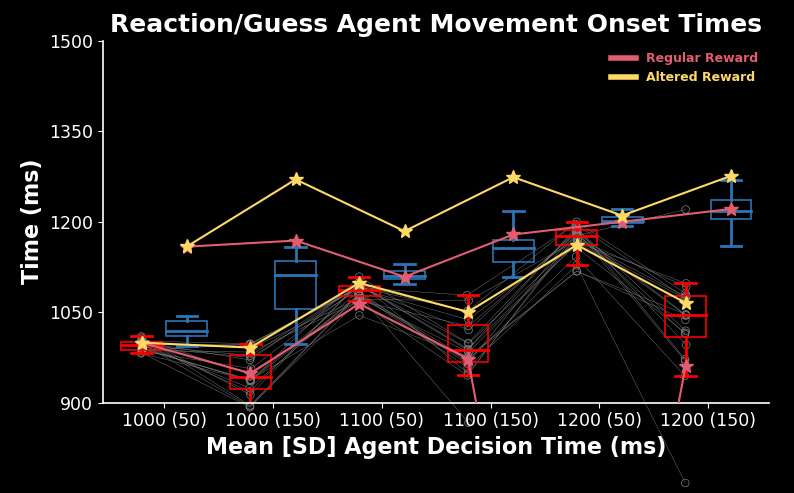

In [219]:
data_metric1 = np.nanmedian(group.agent_reaction_task_leave_time, axis=2)
data_metric2 = np.nanmedian(group.agent_gamble_task_leave_time, axis=2)

regular_reward_metric1 = get_no_switch_metric(model_regular_reward.agent_behavior.reaction_leave_time, metric_type="optimal")
altered_reward_metric1 = get_switch_metric(model_altered_reward.agent_behavior.reaction_leave_time, metric_type="optimal")
unknown_switch_metric1 = get_no_switch_metric(model_altered_reward.agent_behavior.reaction_leave_time, metric_type="optimal")

no_switch_metric2 = get_no_switch_metric(model_regular_reward.agent_behavior.gamble_leave_time, metric_type="optimal")
switch_metric2 = get_switch_metric(model_altered_reward.agent_behavior.gamble_leave_time, metric_type="optimal")
unknown_switch_metric2 = get_no_switch_metric(model_altered_reward.agent_behavior.gamble_leave_time, metric_type="optimal")

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(900, 1650, 150)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[regular_reward_metric1, altered_reward_metric1],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2],
    labels=['Regular Reward','Altered Reward'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel("Time (ms)")
ax.set_xlabel(xlabel)
ax.set_title("Reaction/Guess Agent Movement Onset Times")
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_gamble_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Wins That Were Reaction and Gamble

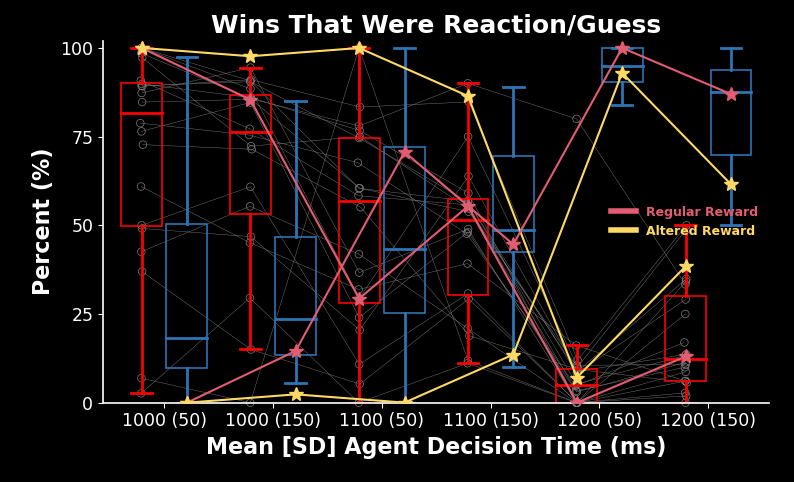

In [220]:
# Out of x number of wins, how many were Reaction and Guess
data_metric1 = group.perc_wins_that_were_reactions
data_metric2 = group.perc_wins_that_were_gambles

regular_reward_metric1 = get_no_switch_metric(
    model_regular_reward.score_metrics.prob_win_reaction, 
    model_regular_reward.score_metrics.prob_win, metric_type="optimal"
) * 100
altered_reward_metric1 = get_switch_metric(
    model_altered_reward.score_metrics.prob_win_reaction, 
    model_altered_reward.score_metrics.prob_win, metric_type="optimal"
) * 100
unknown_switch_metric1 = get_no_switch_metric(
    model_altered_reward.score_metrics.prob_win_reaction, 
    model_altered_reward.score_metrics.prob_win, metric_type="optimal"
) * 100

no_switch_metric2 = get_no_switch_metric(
    model_regular_reward.score_metrics.prob_win_gamble, 
    model_regular_reward.score_metrics.prob_win, metric_type="optimal"
) * 100
switch_metric2 = get_switch_metric(
    model_altered_reward.score_metrics.prob_win_gamble, 
    model_altered_reward.score_metrics.prob_win, metric_type="optimal"
) * 100
unknown_switch_metric2 = get_no_switch_metric(
    model_altered_reward.score_metrics.prob_win_gamble, 
    model_altered_reward.score_metrics.prob_win, metric_type="optimal"
) * 100

# Out of x number of Reaction and Guess decisions, how many of them were wins
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[regular_reward_metric1, altered_reward_metric1],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2],
    labels=['Regular Reward','Altered Reward'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(xlabel)
ax.set_title("Wins That Were Reaction/Guess")
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_gamble_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Incorrects that were Reaction and Guess


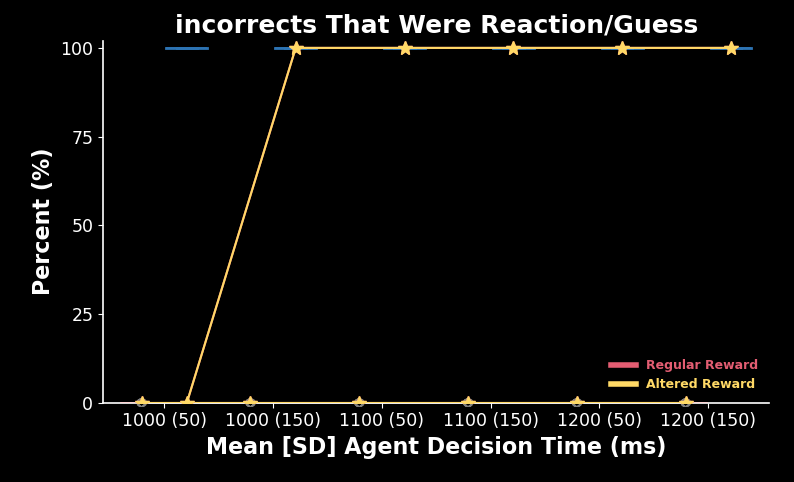

In [221]:
# Out of x number of incorrects, how many were Reaction and Guess
data_metric1 = group.perc_incorrects_that_were_reactions
data_metric2 = group.perc_incorrects_that_were_gambles

regular_reward_metric1 = get_no_switch_metric(
    model_regular_reward.score_metrics.prob_incorrect_reaction, 
    model_regular_reward.score_metrics.prob_incorrect, metric_type="optimal"
) * 100
altered_reward_metric1 = get_switch_metric(
    model_altered_reward.score_metrics.prob_incorrect_reaction, 
    model_altered_reward.score_metrics.prob_incorrect, metric_type="optimal"
) * 100
unknown_switch_metric1 = get_no_switch_metric(
    model_altered_reward.score_metrics.prob_incorrect_reaction, 
    model_altered_reward.score_metrics.prob_incorrect, metric_type="optimal"
) * 100

no_switch_metric2 = get_no_switch_metric(
    model_regular_reward.score_metrics.prob_incorrect_gamble, 
    model_regular_reward.score_metrics.prob_incorrect, metric_type="optimal"
) * 100
switch_metric2 = get_switch_metric(
    model_altered_reward.score_metrics.prob_incorrect_gamble, 
    model_altered_reward.score_metrics.prob_incorrect, metric_type="optimal"
) * 100
unknown_switch_metric2 = get_no_switch_metric(
    model_altered_reward.score_metrics.prob_incorrect_gamble, 
    model_altered_reward.score_metrics.prob_incorrect, metric_type="optimal"
) * 100

# Out of x number of Reaction and Guess decisions, how many of them were incorrects
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[regular_reward_metric1, altered_reward_metric1],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2],
    labels=['Regular Reward','Altered Reward'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(xlabel)
ax.set_title("incorrects That Were Reaction/Guess")
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_gamble_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Percent Indecisions That Were Reaction/Gamble


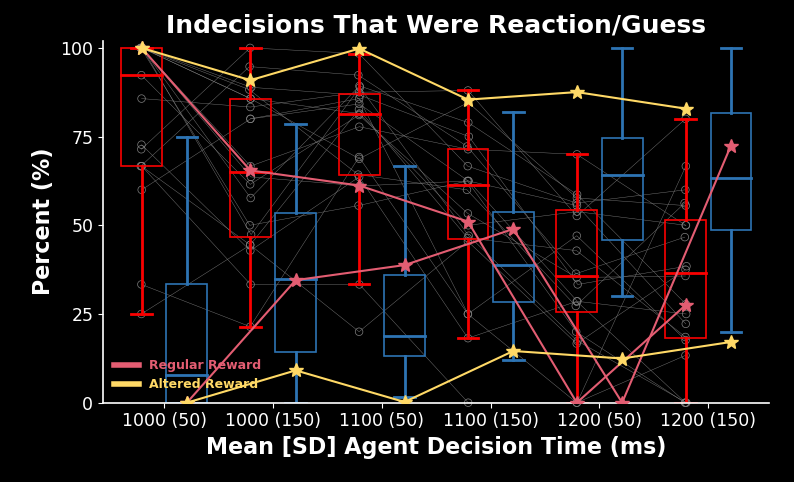

In [222]:
# Out of x number of indecisions, how many were Reaction and Guess
data_metric1 = group.perc_indecisions_that_were_reactions
data_metric2 = group.perc_indecisions_that_were_gambles

regular_reward_metric1 = get_no_switch_metric(
    model_regular_reward.score_metrics.prob_indecision_reaction, 
    model_regular_reward.score_metrics.prob_indecision, metric_type="optimal"
) * 100
altered_reward_metric1 = get_switch_metric(
    model_altered_reward.score_metrics.prob_indecision_reaction, 
    model_altered_reward.score_metrics.prob_indecision, metric_type="optimal"
) * 100
unknown_switch_metric1 = get_no_switch_metric(
    model_altered_reward.score_metrics.prob_indecision_reaction, 
    model_altered_reward.score_metrics.prob_indecision, metric_type="optimal"
) * 100

no_switch_metric2 = get_no_switch_metric(
    model_regular_reward.score_metrics.prob_indecision_gamble, 
    model_regular_reward.score_metrics.prob_indecision, metric_type="optimal"
) * 100
switch_metric2 = get_switch_metric(
    model_altered_reward.score_metrics.prob_indecision_gamble, 
    model_altered_reward.score_metrics.prob_indecision, metric_type="optimal"
) * 100
unknown_switch_metric2 = get_no_switch_metric(
    model_altered_reward.score_metrics.prob_indecision_gamble, 
    model_altered_reward.score_metrics.prob_indecision, metric_type="optimal"
) * 100
# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[regular_reward_metric1, altered_reward_metric1],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2],
    labels=['Regular Reward','Altered Reward'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(xlabel)
ax.set_title("Indecisions That Were Reaction/Guess")
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_gamble_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

OUt of the Reaction/Gamble How many times did they win


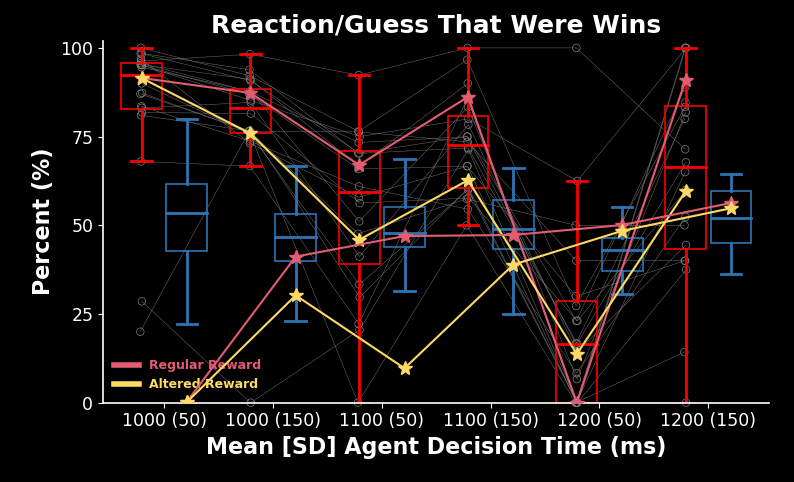

In [223]:
#
# * Out of x number of reactions/gambles, how many were wins
data_metric1 = group.perc_reactions_that_were_wins
data_metric2 = group.perc_gambles_that_were_wins

regular_reward_metric1 = get_no_switch_metric(
    model_regular_reward.score_metrics.prob_win_reaction, 
    model_regular_reward.player_behavior.prob_selecting_reaction, metric_type="optimal"
) * 100
altered_reward_metric1 = get_switch_metric(
    model_altered_reward.score_metrics.prob_win_reaction, 
    model_altered_reward.player_behavior.prob_selecting_reaction, metric_type="optimal"
) * 100
unknown_switch_metric1 = get_no_switch_metric(
    model_altered_reward.score_metrics.prob_win_reaction, 
    model_altered_reward.player_behavior.prob_selecting_reaction, metric_type="optimal"
) * 100

no_switch_metric2 = get_no_switch_metric(
    model_regular_reward.score_metrics.prob_win_gamble, 
    model_regular_reward.player_behavior.prob_selecting_gamble, metric_type="optimal"
) * 100
switch_metric2 = get_switch_metric(
    model_altered_reward.score_metrics.prob_win_gamble, 
    model_altered_reward.player_behavior.prob_selecting_gamble, metric_type="optimal"
) * 100
unknown_switch_metric2 = get_no_switch_metric(
    model_altered_reward.score_metrics.prob_win_gamble, 
    model_altered_reward.player_behavior.prob_selecting_gamble, metric_type="optimal"
) * 100

# Out of x number of Reaction and Guess decisions, how many of them were wins
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[regular_reward_metric1, altered_reward_metric1],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2],
    labels=['Regular Reward','Altered Reward'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(xlabel)
ax.set_title("Reaction/Guess That Were Wins")
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_gamble_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Percent Reaction and Guess That Were Incorrects


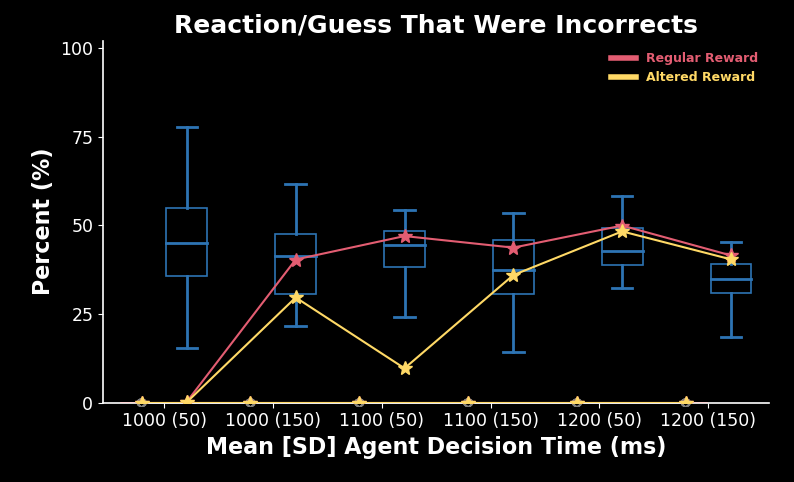

In [224]:
#
# * Out of x number of reactions/gambles, how many were incorrects
data_metric1 = group.perc_reactions_that_were_incorrects
data_metric2 = group.perc_gambles_that_were_incorrects

regular_reward_metric1 = get_no_switch_metric(
    model_regular_reward.score_metrics.prob_incorrect_reaction, 
    model_regular_reward.player_behavior.prob_selecting_reaction, metric_type="optimal"
) * 100
altered_reward_metric1 = get_switch_metric(
    model_altered_reward.score_metrics.prob_incorrect_reaction, 
    model_altered_reward.player_behavior.prob_selecting_reaction, metric_type="optimal"
) * 100
unknown_switch_metric1 = get_no_switch_metric(
    model_altered_reward.score_metrics.prob_incorrect_reaction, 
    model_altered_reward.player_behavior.prob_selecting_reaction, metric_type="optimal"
) * 100

no_switch_metric2 = get_no_switch_metric(
    model_regular_reward.score_metrics.prob_incorrect_gamble, 
    model_regular_reward.player_behavior.prob_selecting_gamble, metric_type="optimal"
) * 100
switch_metric2 = get_switch_metric(
    model_altered_reward.score_metrics.prob_incorrect_gamble, 
    model_altered_reward.player_behavior.prob_selecting_gamble, metric_type="optimal"
) * 100
unknown_switch_metric2 = get_no_switch_metric(
    model_altered_reward.score_metrics.prob_incorrect_gamble, 
    model_altered_reward.player_behavior.prob_selecting_gamble, metric_type="optimal"
) * 100

# Out of x number of Reaction and Guess decisions, how many of them were incorrects
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[regular_reward_metric1, altered_reward_metric1],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2],
    labels=['Regular Reward','Altered Reward'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(xlabel)
ax.set_title("Reaction/Guess That Were Incorrects")
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_gamble_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

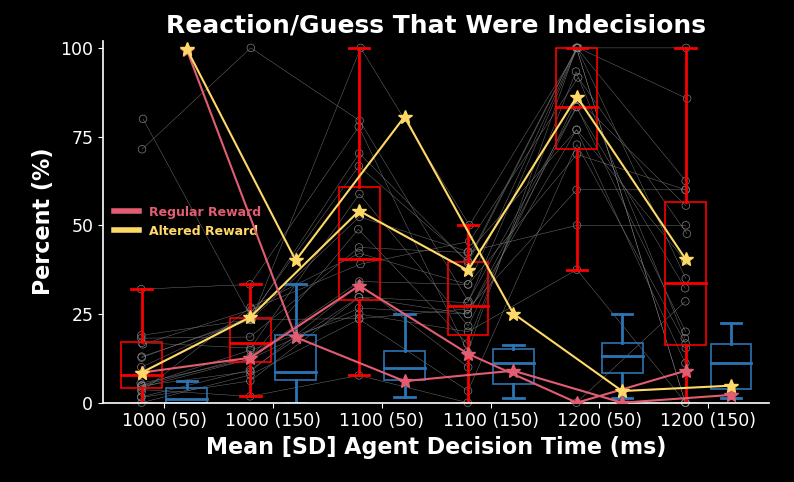

In [225]:
#
# * Out of x number of reactions/gambles, how many were indecisions
data_metric1 = group.perc_reactions_that_were_indecisions
data_metric2 = group.perc_gambles_that_were_indecisions

regular_reward_metric1 = get_no_switch_metric(
    model_regular_reward.score_metrics.prob_indecision_reaction, 
    model_regular_reward.player_behavior.prob_selecting_reaction, metric_type="optimal"
) * 100
altered_reward_metric1 = get_switch_metric(
    model_altered_reward.score_metrics.prob_indecision_reaction, 
    model_altered_reward.player_behavior.prob_selecting_reaction, metric_type="optimal"
) * 100
unknown_switch_metric1 = get_no_switch_metric(
    model_altered_reward.score_metrics.prob_indecision_reaction, 
    model_altered_reward.player_behavior.prob_selecting_reaction, metric_type="optimal"
) * 100

no_switch_metric2 = get_no_switch_metric(
    model_regular_reward.score_metrics.prob_indecision_gamble, 
    model_regular_reward.player_behavior.prob_selecting_gamble, metric_type="optimal"
) * 100
switch_metric2 = get_switch_metric(
    model_altered_reward.score_metrics.prob_indecision_gamble, 
    model_altered_reward.player_behavior.prob_selecting_gamble, metric_type="optimal"
) * 100
unknown_switch_metric2 = get_no_switch_metric(
    model_altered_reward.score_metrics.prob_indecision_gamble, 
    model_altered_reward.player_behavior.prob_selecting_gamble, metric_type="optimal"
) * 100

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(trial_block_titles))
ylocs = np.arange(0, 125, 25)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[regular_reward_metric1, altered_reward_metric1],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"] * 4,
    remove_parentheses_from_labels=False,
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2],
    labels=['Regular Reward','Altered Reward'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(xlabel)
ax.set_title("Reaction/Guess That Were Indecisions")
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_gamble_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()